## Learning from Isochrones: A machine learning approach to estimating stellar properties

### Part 1 - Testing the initial capabilities of classification for an isochrone trained network, assuming a tanh activation function

##### Luco Buise (s1055446)

---

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as ip
import random as ran

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [2]:
# create training data

isochrones = ["FeH05", "FeH0", "FeH-05", "FeH-10", "FeH-15", "FeH-20", "FeH-25"]

isochrone_values = [0.5, 0, -0.5, -1, -1.5, -2, -2.5]

age_to_label = dict()
label_to_age = dict()

# creating dicts to transform labels to ages and ages to labels
all_ages = np.linspace(6, 10.3, 44)
all_ages = np.around(all_ages, decimals=2)
for i, age in enumerate(all_ages):
    age_to_label[age] = i
    label_to_age[i] = age

iso_to_label = dict()
label_to_iso = dict()
    
for i, iso in enumerate(isochrone_values):
    iso_to_label[iso] = i
    label_to_iso[i] = iso
    
Y = np.array([])
X = np.array([])

for i, iso in enumerate(isochrones):

    loga, mag_B, mag_V = np.loadtxt('isochrones/small_data/isoc_' + iso + '.cmd', usecols=(1, 10, 11), unpack=True)
    loga = np.around(loga, decimals=2)
    
    # find the highest and lowest age in this isochrone
    min_age = min(loga)
    max_age = max(loga)
    steps = ((max_age - min_age) / 0.1) + 1
    
    # create the ages
    ages = np.linspace(min_age, max_age, int(steps))
    ages = np.around(ages, decimals=2)
    
    age = np.around(age, decimals = 1)
    
    # transform the values into labels for the network to classify
    y = np.array([[age_to_label[age], iso_to_label[isochrone_values[i]]] for age in ages])
    
    if len(Y) == 0:
        Y = y
    else:
        Y = np.append(Y, y, axis = 0)
    
    for age in ages:
        w = np.where(age == loga)
        
        r = sorted(ran.sample(range(0, len(mag_B[w])), 100))
        
        bv = (mag_B[w] - mag_V[w])[r]
        v = mag_V[w][r]

        x = np.array([np.append(bv, v)])

        if len(X) == 0:
            X = x
        else:
            X = np.append(X, x, axis = 0)

X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).long()
print(X_train.shape, y_train.shape)

torch.Size([308, 200]) torch.Size([308, 2])


In [3]:
# load the regressed testing data from files (see the Creating_Test_Data.ipynb notebook for more information)

X_OC = np.load('openClusters/oc_xdata.npy')
Y_OC = np.load('openClusters/oc_ydata.npy')

X_GC = np.load('globClusters/gc_xdata.npy')
Y_GC = np.load('globClusters/gc_ydata.npy')

X_OC = torch.from_numpy(X_OC).float()
Y_OC = torch.from_numpy(Y_OC).float()

X_GC = torch.from_numpy(X_GC).float()
Y_GC = torch.from_numpy(Y_GC).float()

In [4]:
# transform the test data of X_OC and X_GC by adding their distance modulus to the V values

# transform distances in kpc to distance modulus
def kpc_to_mod(kpc):
    return 5 * np.log10(10 / (kpc * 1000))

oc_distances = np.loadtxt("openClusters/Ages_and_properties.txt", usecols = (3), unpack=True)
gc_distances = np.loadtxt("globClusters/Distances.txt", usecols = (1), unpack=True)

gc_distances = kpc_to_mod(gc_distances) * -1

# subtract distance modulus from the V-magnitudes of the star clusters
for i, d in enumerate(oc_distances):
    X_OC[i][100:] = X_OC[i][100:] - d

for i, d in enumerate(gc_distances):
    X_GC[i][100:] = X_GC[i][100:] - d

In [5]:
# calculate the average MSE-loss of a given model and training data over n runs
def avg_mse_train(model, X, Y, lbl_to_val, n = 1000):
    tot_mse_age = 0
    
    # transform training data in values
    Y = np.array([lbl_to_val[int(y)] for y in Y])
    
    # get average mse
    for i in range(n):
        _, predicted = torch.max(model(X).data, 1)
        # transform predicted classes in values
        predicted = np.array([lbl_to_val[int(p)] for p in predicted])
        tot_mse_age += ((Y - predicted)**2).mean()
        
    return tot_mse_age / n

# calculate the average MSE-loss of a given model and test data over n runs
def avg_mse_test(model, X, Y, lbl_to_val, n = 1000):
    tot_mse = 0
    
    # get average mse
    for i in range(n):
        _, predicted = torch.max(model(X).data, 1)
        # transform predicted classes in values
        predicted = np.array([lbl_to_val[int(p)] for p in predicted])
        tot_mse += ((Y - predicted)**2).mean()
        
    return tot_mse / n

In [6]:
# create and test classification model

nll_loss = nn.NLLLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1

nr_hidden = np.linspace(10,100,10)

mse_age_train = np.array([])
mse_age_oc = np.array([])
mse_age_gc = np.array([])

for i, n in enumerate(nr_hidden):

    # define model
    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=int(n)),
        nn.Tanh(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=int(n), out_features=len(all_ages)),
        nn.Softmax(1)
    )

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # start training
    for step in range(3000):
        pre = model(X_train)
        loss = nll_loss(pre, y_train[:,0])
        kl = kl_loss(model)
        cost = loss + kl_weight*kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    # keep track of mse of training set, open clusters, and globular clusters
    mse_age = avg_mse_train(model, X_train, y_train[:,0], label_to_age)
    mse_age_train = np.append(mse_age_train, mse_age)
    
    mse_age = avg_mse_test(model, X_OC, Y_OC[:,0], label_to_age)
    mse_age_oc = np.append(mse_age_oc, mse_age)
    
    mse_age = avg_mse_test(model, X_GC, Y_GC[:,0], label_to_age)
    mse_age_gc = np.append(mse_age_gc, mse_age)
    
    print("Iteration {} of {} completed!".format(i + 1, len(nr_hidden)))

Iteration 1 of 10 completed!
Iteration 2 of 10 completed!
Iteration 3 of 10 completed!
Iteration 4 of 10 completed!
Iteration 5 of 10 completed!
Iteration 6 of 10 completed!
Iteration 7 of 10 completed!
Iteration 8 of 10 completed!
Iteration 9 of 10 completed!
Iteration 10 of 10 completed!


In [7]:
# do the same but for metallicity

# create and test classification model

nll_loss = nn.NLLLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

nr_hidden = np.linspace(10,100,10)

mse_feh_train = np.array([])
mse_feh_oc = np.array([])
mse_feh_gc = np.array([])

for i, n in enumerate(nr_hidden):

    #define model
    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=int(n)),
        nn.Sigmoid(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=int(n), out_features=len(isochrone_values)),
        nn.Softmax(1)
    )

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # start training
    for step in range(3000):
        pre = model(X_train)
        loss = nll_loss(pre, y_train[:,1])
        kl = kl_loss(model)
        cost = loss + kl_weight*kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    # keep track of mse of training set, open clusters, and globular clusters
    mse_feh = avg_mse_train(model, X_train, y_train[:,1], label_to_iso)
    mse_feh_train = np.append(mse_feh_train, mse_feh)
    
    mse_feh = avg_mse_test(model, X_OC, Y_OC[:,1], label_to_iso)
    mse_feh_oc = np.append(mse_feh_oc, mse_feh)
    
    mse_feh = avg_mse_test(model, X_GC, Y_GC[:,1], label_to_iso)
    mse_feh_gc = np.append(mse_feh_gc, mse_feh)
    
    print("Iteration {} of {} completed!".format(i + 1, len(nr_hidden)))

Iteration 1 of 10 completed!
Iteration 2 of 10 completed!
Iteration 3 of 10 completed!
Iteration 4 of 10 completed!
Iteration 5 of 10 completed!
Iteration 6 of 10 completed!
Iteration 7 of 10 completed!
Iteration 8 of 10 completed!
Iteration 9 of 10 completed!
Iteration 10 of 10 completed!


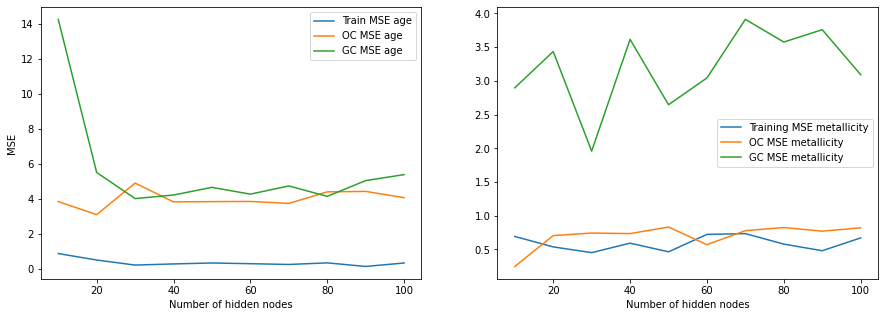

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(nr_hidden, mse_age_train, label = "Train MSE age")
axs[0].plot(nr_hidden, mse_age_oc, label = "OC MSE age")
axs[0].plot(nr_hidden, mse_age_gc, label = "GC MSE age")

axs[1].plot(nr_hidden, mse_feh_train, label = "Training MSE metallicity")
axs[1].plot(nr_hidden, mse_feh_oc, label = "OC MSE metallicity")
axs[1].plot(nr_hidden, mse_feh_gc, label = "GC MSE metallicity")

axs[0].set_xlabel('Number of hidden nodes')
axs[1].set_xlabel('Number of hidden nodes')
axs[0].set_ylabel('MSE')

axs[0].legend()
axs[1].legend()
plt.savefig("Graphs/class_tanh_mse.png")
plt.show()